# Skyline Hospital Time Series Forecasting with XGBoost Solution 1

### 1. Import the necessary libraries and modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

### 2. Load the dataset

In [2]:
df = pd.read_csv("skyline_hospital_time_series_patient_arrivals.csv",
                 index_col=['Date'], 
                 parse_dates=True)

In [ ]:
df.index

In [ ]:
df.info()

### 3. Visualize the data

In [3]:
new_index = pd.date_range(start='2020-05-18', end='2022-12-31', freq='D')
df = df.reindex(new_index)

In [ ]:
df.info()

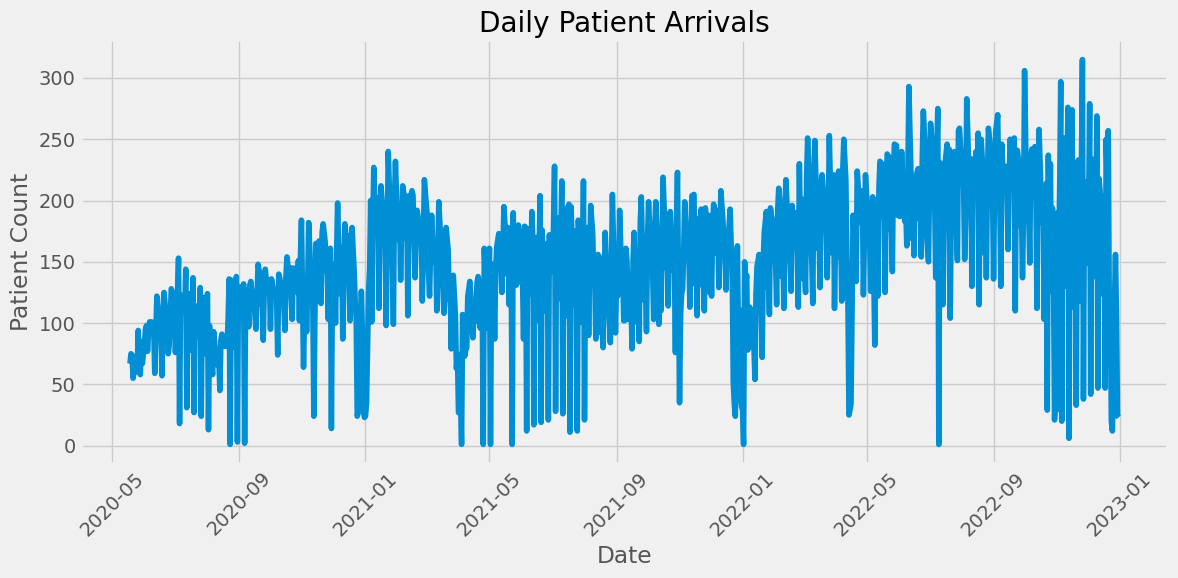

In [4]:
# Visualize the time series data
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=df.index, y='Patients', data=df, ax=ax)

# Set plot title and axis labels
ax.set_title('Daily Patient Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Patient Count')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

In [5]:
missing_vals = df[df.isnull().any(axis=1)]
print(missing_vals)

            Patients
2020-05-24       NaN
2020-05-31       NaN
2020-06-07       NaN
2020-06-14       NaN
2020-06-21       NaN
...              ...
2022-09-18       NaN
2022-09-25       NaN
2022-10-02       NaN
2022-10-09       NaN
2022-10-16       NaN

[102 rows x 1 columns]


In [6]:
df = df.interpolate(method='linear')

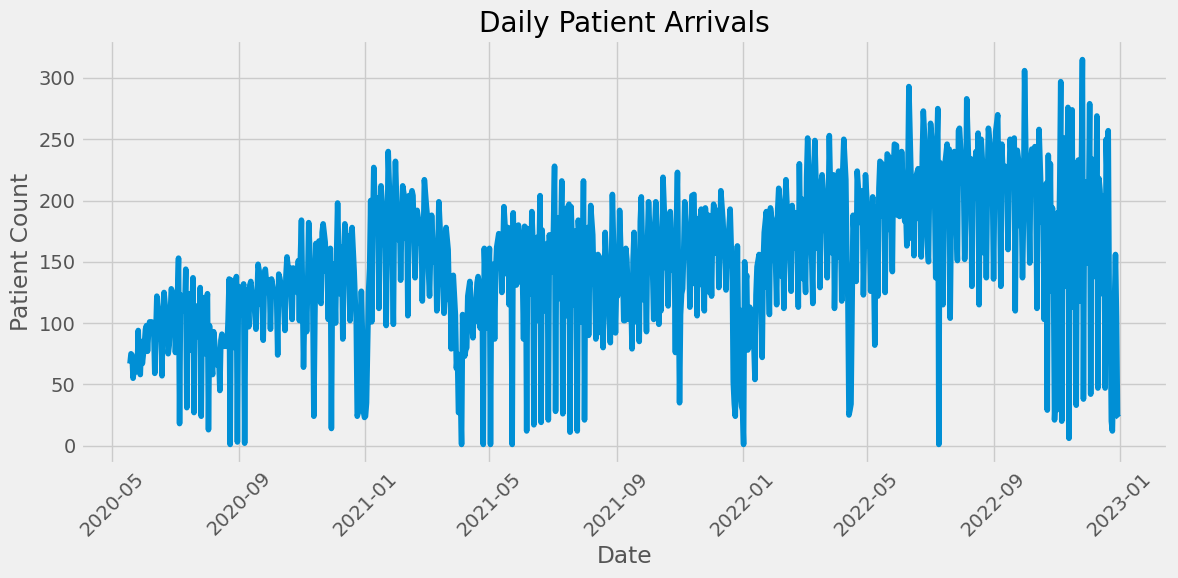

In [8]:
# Visualize the time series data
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=df.index, y='Patients', data=df, ax=ax)

# Set plot title and axis labels
ax.set_title('Daily Patient Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Patient Count')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

## Time series decomposition

In [ ]:
from statsmodels.tsa.seasonal import STL

In [10]:
patients_series = df['Patients']

In [ ]:
# Perform STL decomposition
stl = STL(patients_series, seasonal=7)  # You can adjust the 'seasonal' parameter based on your data's seasonality
result = stl.fit()

In [ ]:
# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5)
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_title('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_title('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_title('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_title('Residual')

plt.show()

## Outlier analysis, detection and handling

In [ ]:
residuals = result.resid
mean_resid = residuals.mean()
std_resid = residuals.std()

print(residuals)
print(f'Mean of Residuals: {mean_resid}')
print(f'Standard Deviation of Residuals: {std_resid}')

In [ ]:
threshold = 0.3 * std_resid
outliers = residuals[(residuals > mean_resid + threshold) | (residuals < mean_resid - threshold)]
print(outliers)

fig, ax = plt.subplots(figsize=(12, 6))
patients_series.plot(ax=ax, label='Original data')
ax.scatter(outliers.index, patients_series[outliers.index], color='red', label='Outliers')
ax.set_title('Patient Arrivals with Outliers')
plt.legend()
plt.show()

In [11]:
## Calculate the IQR and bounds
Q1 = patients_series.quantile(0.25)
Q3 = patients_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 0.1 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Lower Bound: {lower_bound}')
print(f'Upper Bound: {upper_bound}')

Lower Bound: 106.2
Upper Bound: 309.0


In [12]:
def custom_winsorize(x):
    if x < lower_bound:
        return lower_bound
    elif x > upper_bound:
        return upper_bound
    else:
        return x

cleaned_series = patients_series.copy()
cleaned_series = cleaned_series.apply(custom_winsorize)
df['Patients'] = cleaned_series.copy()

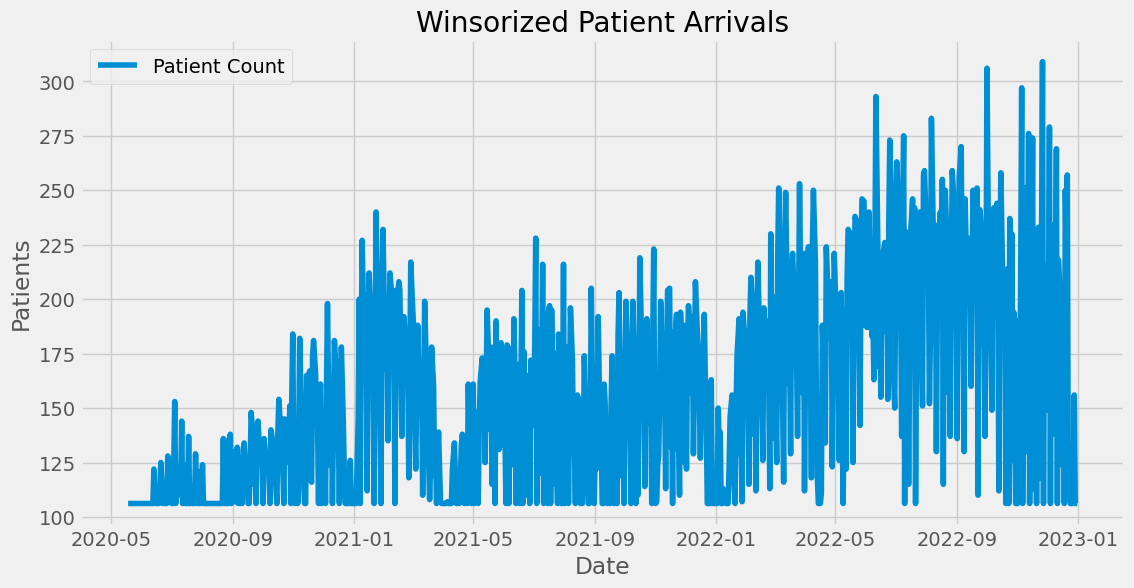

In [13]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the winsorized patient arrivals data
ax.plot(df.index, df['Patients'], label='Patient Count')

# Set the title and labels for the plot
ax.set_title('Winsorized Patient Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Patients')

# Show the legend
ax.legend()

# Display the plot
plt.show()

In [ ]:
plt.scatter(range(df.shape[0]), np.sort(df['Patients'].values))
plt.ylabel('Patients')
plt.title("Patient Counts Data Distribution")
sns.despine()

In [ ]:
sns.distplot(df['Patients'])
plt.title("Distribution of Patient Counts")
sns.despine()

In [ ]:
print("Skewness: %f" % df['Patients'].skew())
print("Kurtosis: %f" % df['Patients'].kurt())

In [ ]:
df.describe()

The **mean (average) number of patients is 158.6**, which represents the central tendency of the dataset.

The **standard deviation** is 45.86, which indicates the dispersion or spread of the data. A higher standard deviation means the data points are more spread out, while a lower standard deviation indicates that the data points are closer to the mean.

The **minimum** number of patients is 106.2, and the **maximum** number of patients is 309. This shows the range of the dataset.
The **25th percentile (Q1)** is 114, the **50th percentile (Q2 or median)** is 153, and the **75th percentile (Q3)** is 192. These values divide the data into four equal parts and can help you understand the distribution of the data.

The **skewness** value is 0.571263, which is greater than 0, indicating a **positive or right-skewed distribution**. This means that the tail on the right side of the distribution is longer or fatter than the left side. In a right-skewed distribution, the mean is typically greater than the median.

The **kurtosis** value is -0.577239, which is less than 0, indicating a **platykurtic distribution**. This means that the distribution has lighter tails and a flatter peak than the normal distribution. In a platykurtic distribution, **extreme values are less likely to occur** than in a normal distribution.

## Feature engineering

In [14]:
def create_features(df, label=None):
    """
    Create time series features from the datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    
    window_size = 7  # 7-day rolling window

    # Rolling minimum
    df['rolling_min'] = df['Patients'].rolling(window=window_size).min()

    # Rolling maximum
    df['rolling_max'] = df['Patients'].rolling(window=window_size).max()

    # Rolling sum
    df['rolling_sum'] = df['Patients'].rolling(window=window_size).sum()

    # Rolling mean
    df['rolling_mean'] = df['Patients'].rolling(window=window_size).mean()

    # Rolling median
    df['rolling_median'] = df['Patients'].rolling(window=window_size).median()

    # Rolling standard deviation
    df['rolling_std'] = df['Patients'].rolling(window=window_size).std()

    # Rolling quantile (25th percentile)
    quantile_25 = 0.25
    df['rolling_quantile_25'] = df['Patients'].rolling(window=window_size).quantile(quantile_25)
    
    # Rolling quantile(50th percentile)
    quantile_50 = 0.50
    df['rolling_quantile_50'] = df['Patients'].rolling(window=window_size).quantile(quantile_50)

    # Rolling quantile (75th percentile)
    quantile_75 = 0.75
    df['rolling_quantile_75'] = df['Patients'].rolling(window=window_size).quantile(quantile_75)

    return df

df = create_features(df)

In [ ]:
df.dtypes

In [ ]:
df.info()

In [ ]:
df.head()

## Time series cross-validation

In [15]:
from sklearn.model_selection import TimeSeriesSplit

In [16]:
tss = TimeSeriesSplit(n_splits=8, test_size=119, gap=1)
df = df.sort_index()

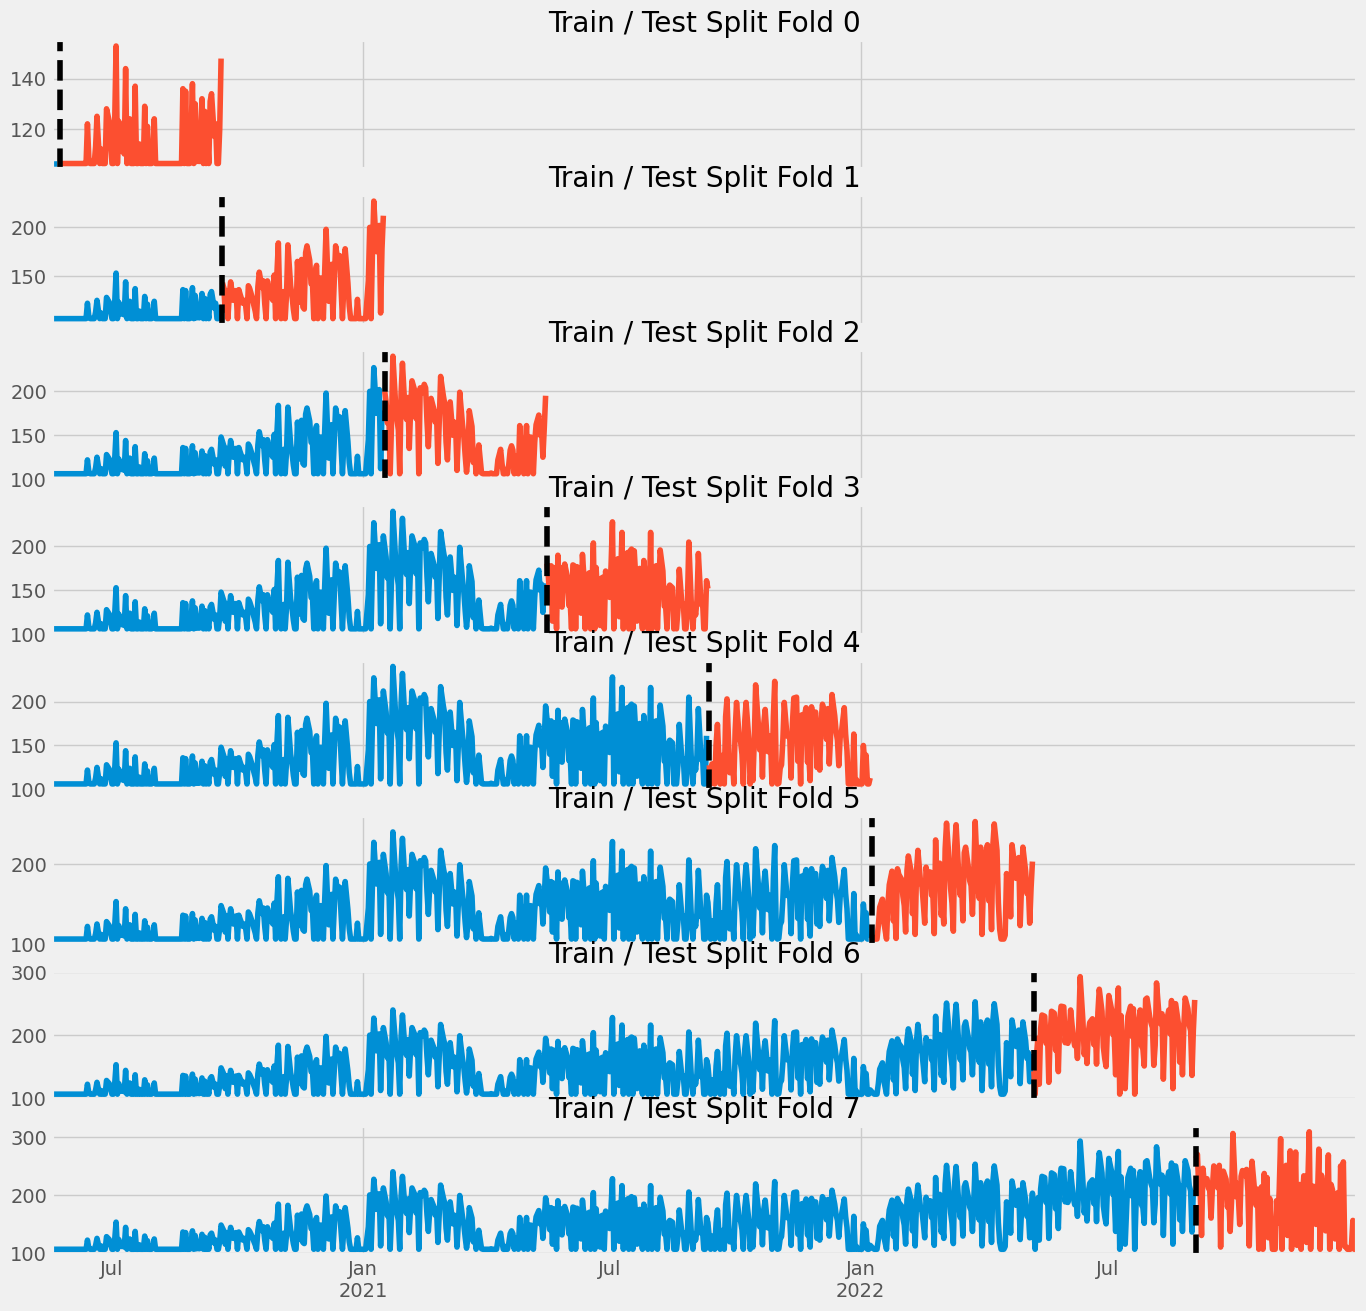

In [19]:
fig, axs = plt.subplots(8, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    train['Patients'].plot(ax=axs[fold],
                           label='Training Set',
                           title=f'Train / Test Split Fold {fold}')
    test['Patients'].plot(ax=axs[fold], label='Test Set')
    
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

## Forecasting horizon

## Lag features

In [20]:
def add_lags(df):
    target_map = df['Patients'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('180 days')).map(target_map)
    return df

df = add_lags(df)

This Python code defines a function called add_lags that takes a DataFrame df as input and adds three new columns to the DataFrame representing lag features. Here's a step-by-step explanation of the code:

`target_map = df['Patients'].to_dict()`: This line creates a dictionary called target_map from the 'Patients' column of the input DataFrame df. The keys of the dictionary are the DataFrame index values (dates), and the values are the corresponding patient counts.

`df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)`: This line calculates the 30-day lag feature. It subtracts 30 days from the DataFrame index (which are dates) using the pd.Timedelta function. Then, it maps the resulting dates to the patient counts using the target_map dictionary. The resulting lag feature is added as a new column named 'lag1' in the DataFrame.

`df['lag2'] = (df.index - pd.Timedelta('90 days')).map(target_map)`: This line calculates the 90-day lag feature, similar to the 30-day lag feature calculation. It subtracts 90 days from the DataFrame index and maps the resulting dates to the patient counts using the target_map dictionary. The resulting lag feature is added as a new column named 'lag2' in the DataFrame.

`df['lag3'] = (df.index - pd.Timedelta('180 days')).map(target_map)`: This line calculates the 180-day lag feature, similar to the previous lag feature calculations. It subtracts 180 days from the DataFrame index and maps the resulting dates to the patient counts using the target_map dictionary. The resulting lag feature is added as a new column named 'lag3' in the DataFrame.

`return df:` The function returns the modified DataFrame with the added lag features.

In summary, the `add_lags` function takes a DataFrame with a 'Patients' column and adds three new lag features based on 30-day, 90-day, and 180-day lags, which may help capture relevant patterns or seasonality in the patient arrivals data for time series modeling.

In [ ]:
df.head()

## Train using cross-validation

In [21]:
# Define the error metrics

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [22]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=8, test_size=119, gap=1)
df = df.sort_index()

fold = 0
preds = []

rmse_scores = []
mape_scores = []
smape_scores = []

# Initialize an empty DataFrame to store actual and predicted values
actual_vs_pred_df = pd.DataFrame()

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['day_of_year', 'day_of_week', 'month', 'rolling_min', 'rolling_max',
                'rolling_sum', 'rolling_quantile_25', 'rolling_quantile_50', 
                'rolling_quantile_75', 'rolling_mean', 'rolling_median', 
                'rolling_std', 'lag1', 'lag2', 'lag3']

    TARGET = 'Patients'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=900, 
                           early_stopping_rounds=50, 
                           tree_method='hist',
                           objective='reg:squarederror', 
                           max_depth=3, 
                           min_child_weight=3, 
                           gamma=0, 
                           learning_rate=0.01, 
                           colsample_bytree=0.9, 
                           subsample=0.7,
                           reg_lambda=0)
    
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)
    
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    smape_scores.append(smape)
    
    # Store actual and predicted values along with their datetime index in the DataFrame
    temp_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred}, index=df.iloc[val_index].index)
    actual_vs_pred_df = pd.concat([actual_vs_pred_df, temp_df])

[0]	validation_0-rmse:104.64300	validation_1-rmse:111.40761
[100]	validation_0-rmse:39.08043	validation_1-rmse:46.54263
[200]	validation_0-rmse:14.44920	validation_1-rmse:23.20963
[300]	validation_0-rmse:5.50580	validation_1-rmse:15.74851
[400]	validation_0-rmse:2.09799	validation_1-rmse:13.39210
[500]	validation_0-rmse:0.77570	validation_1-rmse:12.60788
[600]	validation_0-rmse:0.29858	validation_1-rmse:12.34747
[700]	validation_0-rmse:0.11038	validation_1-rmse:12.24834
[800]	validation_0-rmse:0.04039	validation_1-rmse:12.21201
[899]	validation_0-rmse:0.01495	validation_1-rmse:12.19888
[0]	validation_0-rmse:110.68872	validation_1-rmse:139.15112
[100]	validation_0-rmse:40.96355	validation_1-rmse:65.02502
[200]	validation_0-rmse:15.59999	validation_1-rmse:38.95735
[300]	validation_0-rmse:6.67502	validation_1-rmse:30.50822
[400]	validation_0-rmse:3.88844	validation_1-rmse:28.07639
[500]	validation_0-rmse:3.00238	validation_1-rmse:27.17006
[600]	validation_0-rmse:2.60333	validation_1-rmse:

## Error metrics

In [23]:
# Print the results
print(f'RMSE across folds: {np.mean(rmse_scores):.3f}')
print(f'MAPE across folds: {np.mean(mape_scores):.3f}%')
print(f'sMAPE across folds: {np.mean(smape_scores):.3f}%')

RMSE across folds: 27.473
MAPE across folds: 12.811%
sMAPE across folds: 13.070%


In [ ]:
# Display the DataFrame
actual_vs_pred_df.tail()

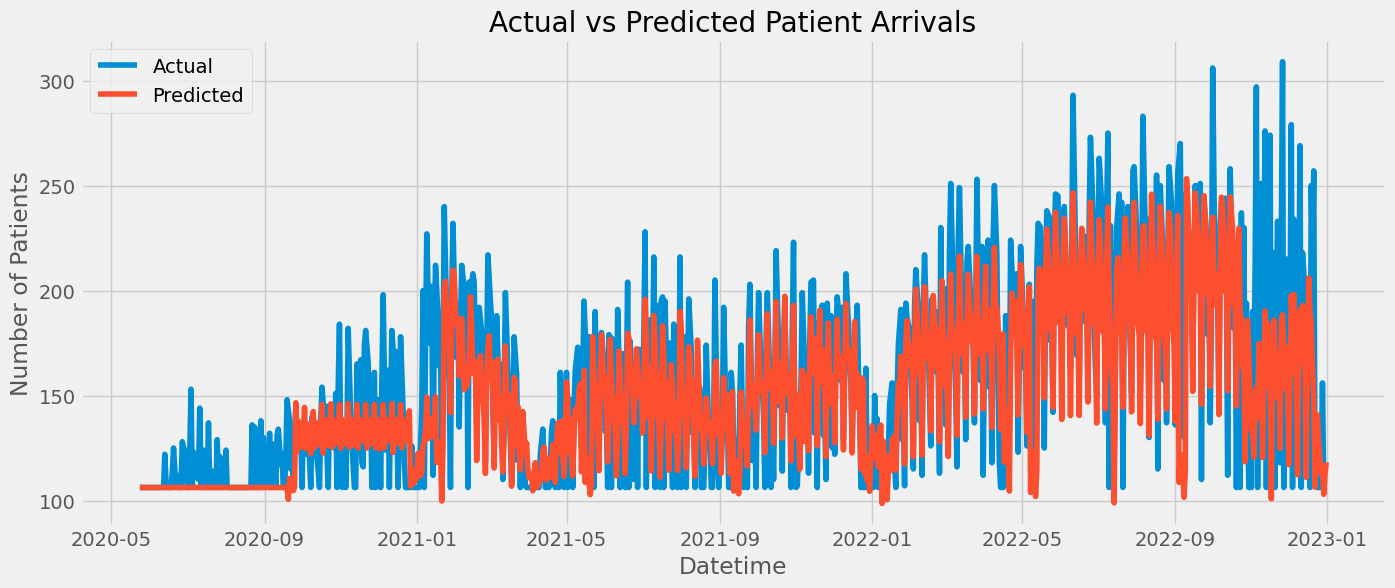

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual')
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Predicted'], label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('Number of Patients')
plt.title('Actual vs Predicted Patient Arrivals')
plt.legend()
plt.show()

## Predicting the future

In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['day_of_year', 'day_of_week', 'month', 'rolling_min', 'rolling_max',
            'rolling_sum', 'rolling_quantile_25', 'rolling_quantile_50', 'rolling_quantile_75', 
            'rolling_mean', 'rolling_median', 'rolling_std', 'lag1', 'lag2', 'lag3']


TARGET = 'Patients'

X_all = df[FEATURES]
y_all = df[TARGET]
    

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=900, 
                       early_stopping_rounds=50, 
                       tree_method='hist',
                       objective='reg:squarederror', 
                       max_depth=3, 
                       min_child_weight=3, 
                       gamma=0, 
                       learning_rate=0.01, 
                       colsample_bytree=0.9, 
                       subsample=0.7,
                       reg_lambda=0)
    
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)],
       verbose=100)

In [ ]:
df.index.max()

In [ ]:
# Create future DataFrame
future = pd.date_range('2022-12-31', '2023-06-28', freq='D')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_with_features = df_and_future.query('isFuture').copy()

In [ ]:
future_with_features.tail()

## Feature Importance

In [ ]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
feature_importance

In [ ]:
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')

## Predict the future

In [ ]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])

In [ ]:
future_with_features.info()

In [ ]:
future_with_features.describe()

In [ ]:
# Create a new figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_with_features.index, y=future_with_features['pred'],
                         name='Predicted Patient Arrivals',
                         line=dict(color='blue', width=2),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Patients</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))

fig.update_layout(
    title='Future Forecasts of Patient Arrivals',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Predicted Patient Arrivals',
    template='plotly_white'
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()

## Save the model

In [ ]:
# Save the model
reg.save_model('model.json')

In [ ]:
!dir

## Reload the model

In [ ]:
# Reload the model
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')

future_with_features['pred'] = reg_new.predict(future_with_features[FEATURES])

# Create a new figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_with_features.index, y=future_with_features['pred'],
                         name='Predicted Patient Arrivals',
                         line=dict(color='blue', width=2),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Patients</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))

fig.update_layout(
    title='Future Forecasts of Patient Arrivals',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Predicted Patient Arrivals',
    template='plotly_white'
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()

In [ ]:
!pip freeze requirements.txt